<a href="https://colab.research.google.com/github/TheRadDani/Text-to-speech-recognition/blob/main/Text_to_speech_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install deep_phonemizer

In [3]:
import torch
import torchaudio
import matplotlib
import matplotlib.pyplot as plt

import IPython

matplotlib.rcParams['figure.figsize'] = [16.0, 4.8]
torch.random.manual_seed(69)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [14]:
symbols = '_-!\'(),.:;? abcdefghijklmnopqrstuvwxyz'
look_up = {s: i for i, s in enumerate(symbols)}
symbols = set(symbols)
a = ["teffy" for _ in range(10)]

def text_to_sequence(text):
    sequence = [look_up[s] for s in text.lower() if s in symbols]
    return sequence

text_to_sequence("teffy")

[31, 16, 17, 17, 36]

In [18]:
processor = torchaudio.pipelines.TACOTRON2_WAVERNN_CHAR_LJSPEECH.get_text_processor()
processed_text, lengths = processor("teffy")
print(processed_text)
print(lengths)

tensor([[31, 16, 17, 17, 36]])
tensor([5], dtype=torch.int32)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


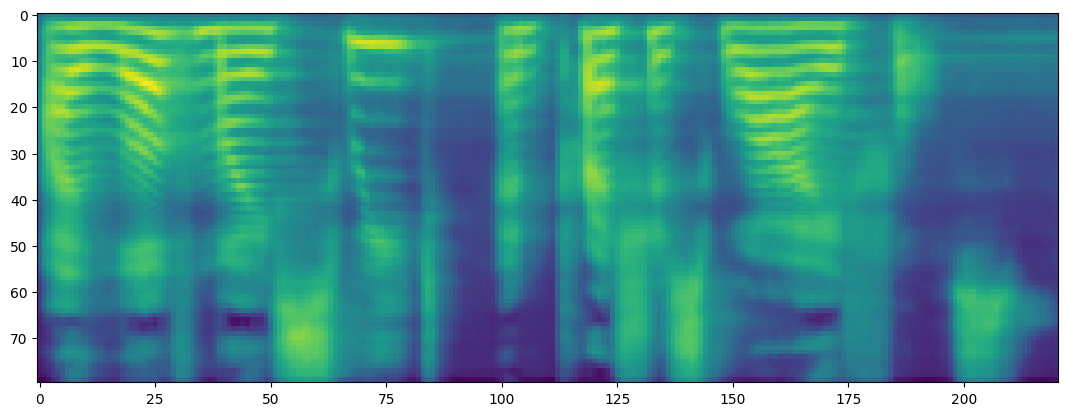

In [62]:
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH
processor = bundle.get_text_processor()
tacotron2_model = bundle.get_tacotron2().to(device)

input_text = "I love my sweet and precious Wife!"
with torch.inference_mode():
    processed_text, lengths = processor(input_text)
    processed_text = processed_text.to(device)
    lengths = lengths.to(device)
    spec = tacotron2_model.infer(processed_text, lengths)

plt.imshow(spec[0].squeeze().cpu().detach())


torch.Size([80, 193])
torch.Size([80, 201])
torch.Size([80, 197])


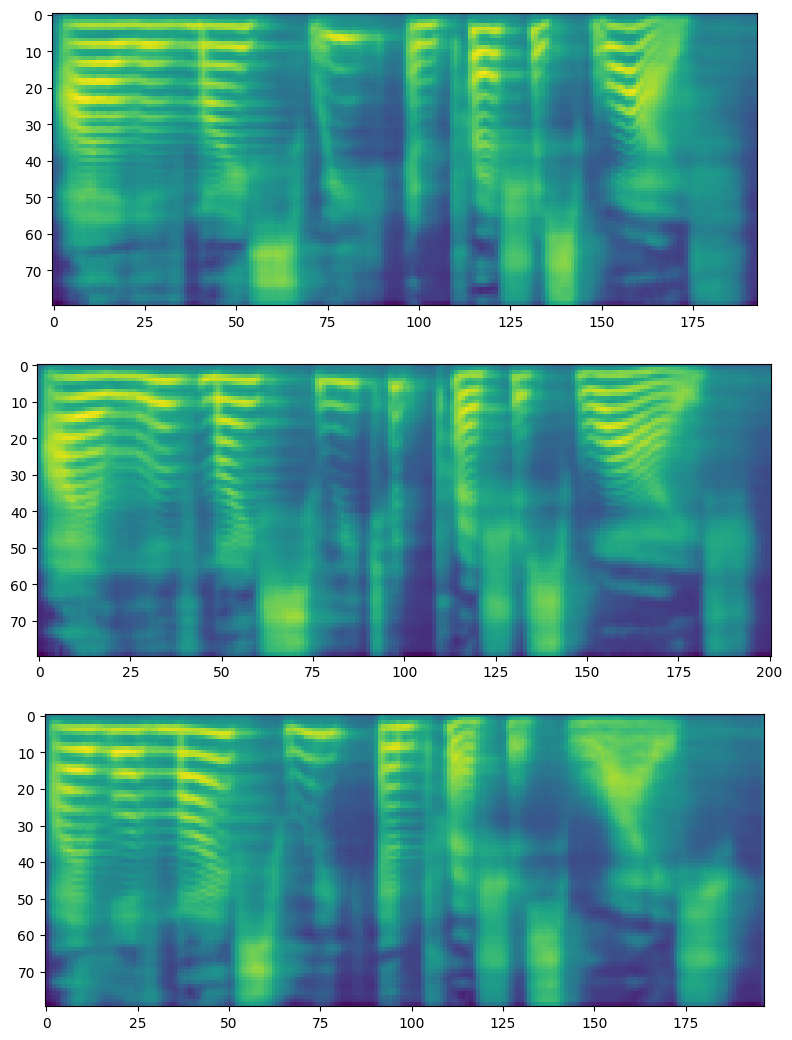

In [63]:
fig, ax = plt.subplots(3, 1, figsize=(16, 4.3 * 3))
for i in range(3):
  with torch.inference_mode():
    spec, spec_lengths, _ = tacotron2_model.infer(processed_text, lengths)
  print(spec[0].shape)
  ax[i].imshow(spec[0].squeeze().cpu().detach())

plt.show()

In [66]:
# Wave RNN and Griffin-Lim models for wave generation
def wave_generation(model):

  bundle = None

  if model == "wave_rnn":
    bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH
  elif model == "griffin_lim":
    bundle = torchaudio.pipelines.TACOTRON2_GRIFFINLIM_PHONE_LJSPEECH
  else:
    raise Exception("Invalid model")


  processor = bundle.get_text_processor()
  tacotron2_model = bundle.get_tacotron2().to(device) # spectrogram generation
  vocoder = bundle.get_vocoder().to(device) # waveform synthesis

  with torch.inference_mode():
    processed_text, lengths = processor(input_text)
    processed_text = processed_text.to(device)
    lengths = lengths.to(device)
    spec, spec_lengths, _ = tacotron2_model.infer(processed_text, lengths)
    waveforms, lengths = vocoder(spec, spec_lengths)

  return spec, waveforms, vocoder

In [68]:
model = "griffin_lim"
spec, waveforms, vocoder = wave_generation(model)

In [85]:
def plot_wave(spec, waveforms):
  fig, [ax1, ax2] = plt.subplots(2 , 1, figsize=(16,9))

  ax1.imshow(spec[0].squeeze().cpu().detach())
  ax2.plot(waveforms[0].squeeze().cpu().detach())

audio_file  =  "wife.wav"
torchaudio.save(audio_file, waveforms[0:1].cpu(), sample_rate=vocoder.sample_rate)
IPython.display.Audio(audio_file)

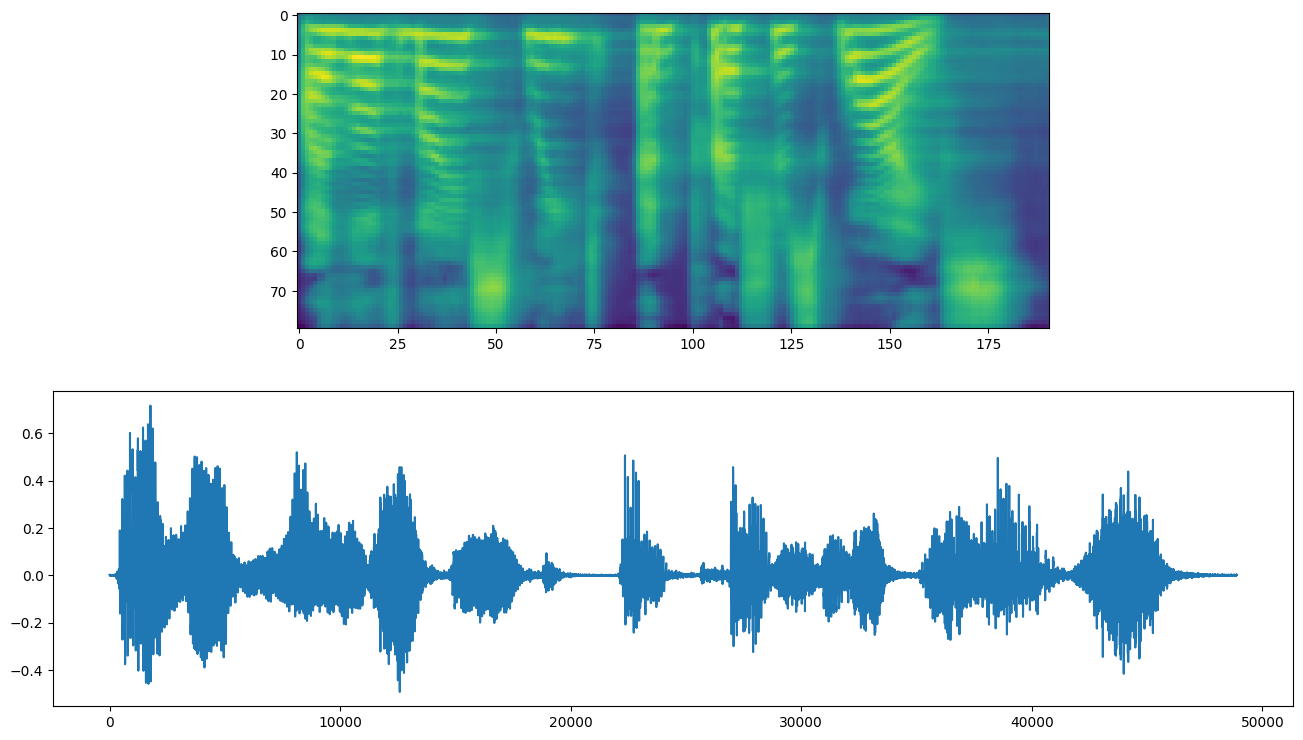

In [86]:
plot_wave(spec, waveforms)

In [91]:
model = "griffin_lim"
spec, _, vocoder = wave_generation(model)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


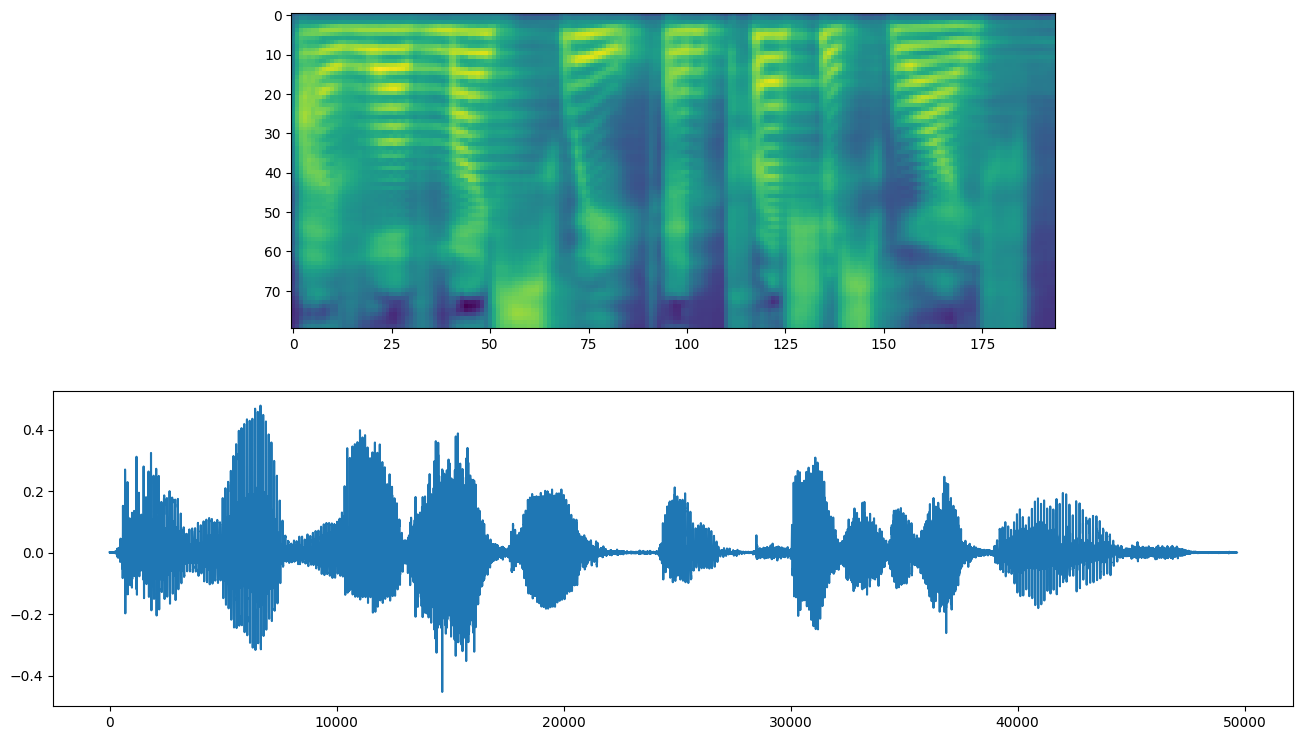

In [92]:
# Using Waveglow as vocoder from Nvidia
waveglow = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_waveglow',
                          model_math='fp32', pretrained=False).to(device)
checkpoint = torch.hub.load_state_dict_from_url('https://api.ngc.nvidia.com/v2/models/nvidia/waveglowpyt_fp32/versions/1/files/nvidia_waveglowpyt_fp32_20190306.pth',
                                                progress=False, map_location=device)
state_dict = {key.replace("module.",""): value for key, value in checkpoint['state_dict'].items()}
waveglow.load_state_dict(state_dict)
waveglow = waveglow.remove_weightnorm(waveglow)
waveglow = waveglow.to(device)
waveglow = waveglow.eval()

with torch.no_grad():
  waveforms = waveglow.infer(spec)

plot_wave(spec, waveforms)

In [93]:
audio_file  =  "wife_waveglow.wav"
torchaudio.save(audio_file, waveforms[0:1].cpu(), sample_rate=22050)
IPython.display.Audio(audio_file)